In [1]:
%pip install ipywidgets

import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
assert torch.cuda.is_available()

In [3]:
class Generator(nn.Module):
    
    def __init__(self, d=128):
        
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            self._get_transpconv_block(100, d*8, 4, 1, 0),
            self._get_transpconv_block(d*8, d*4, 4, 2, 1),
            self._get_transpconv_block(d*4, d*2, 4, 2, 1),
            self._get_transpconv_block(d*2, d, 4, 2, 1),
            self._get_transpconv_block(d, 1, 4, 2, 1, nn.Tanh),
        )
    
    def _get_transpconv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.ReLU):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
        ),
            nn.BatchNorm2d(out_channels),
            activation()
        )

    # forward method
    def forward(self, latents):
        return self.model(latents)

In [4]:
G = Generator()

In [5]:
z = torch.randn((1, 100)).view(-1, 100, 1, 1)
G(z).shape

torch.Size([1, 1, 64, 64])

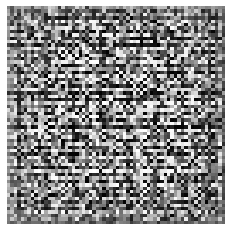

In [6]:
# Visualize the output tensor as a grayscale image
plt.imshow(G(z).view(64, 64).data.numpy(), cmap='gray')
_ = plt.axis('off')

In [7]:
class Discriminator(nn.Module):

    def __init__(self, d=128):

        super(Discriminator, self).__init__()

        # NOTE: the paper suggests to use strided convolution instead of max pooling
        # to pool the feature maps
        self.model = nn.Sequential(
            self._get_conv_block(1, d, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            self._get_conv_block(d, d*2, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            self._get_conv_block(d*2, d*4, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            self._get_conv_block(d*4, d*8, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            self._get_conv_block(d*8, 1, 4, 1, 0, nn.Sigmoid()),
        )
    
    def _get_conv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation):

        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding,
                bias=False
        ),
            nn.BatchNorm2d(out_channels),
            activation
        )

    # forward method
    def forward(self, images):
        return self.model(images)

In [8]:
D = Discriminator()
_ = D.eval()

In [9]:
img = torch.randn((1, 1, 64, 64))
D(img).squeeze(axis=-1).squeeze(axis=-1)

tensor([[0.4971]], grad_fn=<SqueezeBackward1>)

In [10]:
# training parameters
batch_size = 1024
lr = 0.0005
train_epoch = 20

# data_loader
img_size = 64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = Generator(128)
D = Discriminator(128)
# G.weight_init(mean=0.0, std=0.02)
# D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:312: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, af

In [11]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in tqdm.tqdm(train_loader):
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    # show_result((epoch+1), save=True, path=p, isFix=False)
    # show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

training start!


100%|██████████| 59/59 [03:58<00:00,  4.04s/it]


[1/20] - ptime: 238.63, loss_d: 1.556, loss_g: 0.776


 39%|███▉      | 23/59 [01:33<02:25,  4.05s/it]


KeyboardInterrupt: 

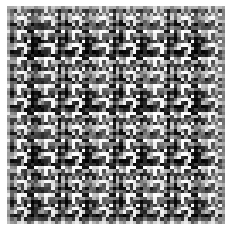

In [15]:
plt.imshow(G(z.cuda()).view(64, 64).detach().cpu().numpy(), cmap='gray')
_ = plt.axis('off')